# Facial Keypoints Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage, misc

# Read the data

In [2]:
train = pd.read_csv("./data/training.csv")
test = pd.read_csv("./data/test.csv")
lookup = pd.read_csv("./data/IdLookupTable.csv")
sample = pd.read_csv("./data/SampleSubmission.csv")

In [3]:
print("Train data length = ", len(train))
print("Test data length = ", len(test))

Train data length =  7049
Test data length =  1783


# Check for nulls and split into good data and bad data

In [4]:
# check for null values
print(f"Feature \t\t\t Missing \t Percentage\n")
for k, v in train.isna().sum().items():
    print(f"{k !s:30} :{v :8} \t {round(v/len(train), 2)}%")

Feature 			 Missing 	 Percentage

left_eye_center_x              :      10 	 0.0%
left_eye_center_y              :      10 	 0.0%
right_eye_center_x             :      13 	 0.0%
right_eye_center_y             :      13 	 0.0%
left_eye_inner_corner_x        :    4778 	 0.68%
left_eye_inner_corner_y        :    4778 	 0.68%
left_eye_outer_corner_x        :    4782 	 0.68%
left_eye_outer_corner_y        :    4782 	 0.68%
right_eye_inner_corner_x       :    4781 	 0.68%
right_eye_inner_corner_y       :    4781 	 0.68%
right_eye_outer_corner_x       :    4781 	 0.68%
right_eye_outer_corner_y       :    4781 	 0.68%
left_eyebrow_inner_end_x       :    4779 	 0.68%
left_eyebrow_inner_end_y       :    4779 	 0.68%
left_eyebrow_outer_end_x       :    4824 	 0.68%
left_eyebrow_outer_end_y       :    4824 	 0.68%
right_eyebrow_inner_end_x      :    4779 	 0.68%
right_eyebrow_inner_end_y      :    4779 	 0.68%
right_eyebrow_outer_end_x      :    4813 	 0.68%
right_eyebrow_outer_end_y      :    481

In [5]:
# split into good data and bad data
good_train = train.dropna()
bad_train = train.drop(index=good_train.index)

# Work on the Good Data

In [6]:
good_train.shape

(2140, 31)

In [7]:
good_train["Image"].head()

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

# Function that extracts the images and targets from a CSV file

In [8]:
def get_images(data):
    images = []

    # prepare the image
    for img in iter(data.loc[:, "Image"]):
        img = np.array(img.split(), dtype=float)
        img = img.reshape(96, 96, 1)
        images.append(img)
    return np.array(images)

def get_xy(data):
    images = get_images(data)
    targets = np.array(data.iloc[:, :-1], dtype=float)
    return images, targets

In [9]:
images, targets = get_xy(good_train)

In [10]:
print("Shape of images = ", images.shape)
print("Shape of targets = ", targets.shape)

Shape of images =  (2140, 96, 96, 1)
Shape of targets =  (2140, 30)


# Display the images

In [11]:
def show_images(img, feat):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(feat[0::2], feat[1::2], c="r", marker="x")

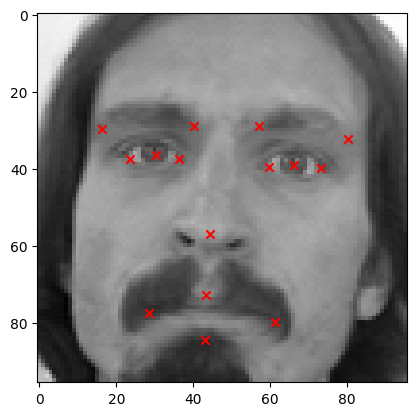

In [12]:
show_images(images[0], targets[0])
bob_image, bob_feats = images[1], targets[1]

## Augmentation
We can build a larger train set by augmenting the already existing data. This process will account for variations in the pictures of a given individual, such as different viewing angles, lighting, camera quality etc.

Types of augmentation:
* Flippiing
* Rotation
* Cropping
* Adding Noise
* Blurring
* Brightness

In [13]:
# display the augmentation
def show_augmentation(img, feat, img_f, feat_f):
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 2, 1)
    plt.scatter(feat[0::2], -feat[1::2], c="r", marker="x")

    plt.subplot(2, 2, 2)
    plt.scatter(feat_f[0::2], -feat_f[1::2], c="r", marker="x")

    plt.subplot(2, 2, 3)
    show_images(img, feat)

    plt.subplot(2, 2, 4)
    show_images(img_f, feat_f)

## Flip

In [14]:
def aug_flip(images, features):
    flipped_images = np.flip(images, axis=2)

    flipped_features = features.copy()
    for i, feat in enumerate(flipped_features):
        for j, val in enumerate(feat):
            if j % 2 == 0:
                flipped_features[i][j] = 96 - val
    return flipped_images, flipped_features

augmentation_functions = {
    "flip": aug_flip
}

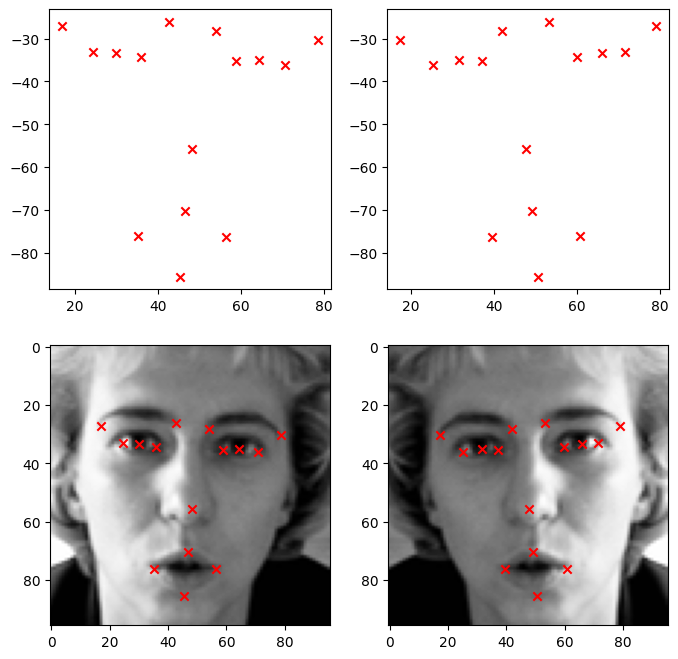

In [15]:
flip_imgs, flipped_feats = aug_flip(images[:5], targets[:5])
i = 1
show_augmentation(images[i], targets[i], flip_imgs[i], flipped_feats[i])

## Crop

In [16]:
def aug_crop(images, features):
    cropped_images = images.copy()

    for i in range(len(images)):
        cropped_images[i, :, :10] = 0
        cropped_images[i, :, 86:] = 0
        cropped_images[i, :10, :] = 0
        cropped_images[i, 86:, :] = 0
    return cropped_images, features

augmentation_functions["crop"] = aug_crop

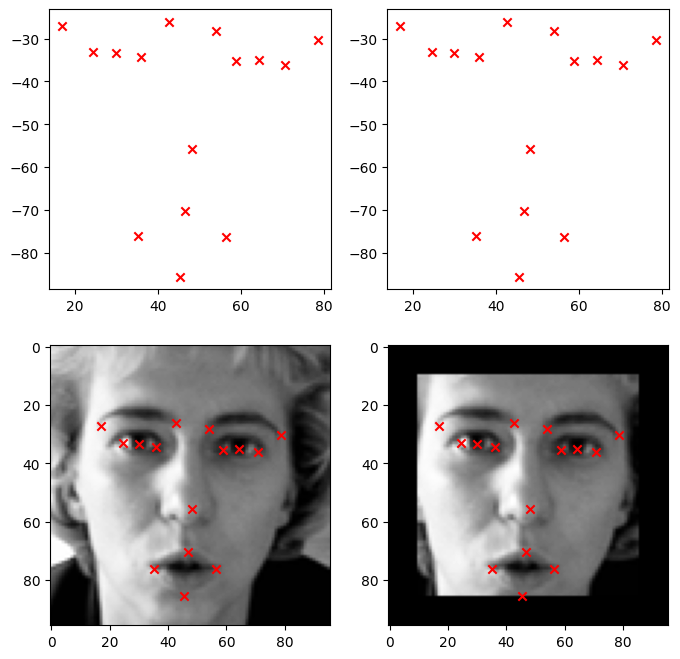

In [17]:
cropped_images, features = aug_crop(images[:5], targets[:5])
show_augmentation(images[1], features[1], cropped_images[1], features[1])

## Rotation

In [18]:
def rotate_points(points, angle):
    # shift points so that the center of rotation is at the origin
    points_copy = points.copy()
    points_copy -= 48

    # rotation matrix
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))

    # rotate the points
    for i in range(0, len(points), 2):
        xy = np.array([points_copy[i], points_copy[i+1]])
        xy_rot = R @ xy
        points_copy[i], points_copy[i+1] = xy_rot

    # shift the points back to their original spot
    points_copy += 48
    
    return points_copy

In [19]:
# lets make an util that give us rotated images and targets
def aug_rotate(images, features, angle):
    rotated_images = []
    for img in images:
        img_rot = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(img_rot)
        
    rotated_features=[]
    for feat in features:
        feat_rot = rotate_points(feat, angle)
        rotated_features.append(feat_rot)
        
    
    return np.array(rotated_images), np.array(rotated_features)

augmentation_functions['rotate'] = aug_rotate

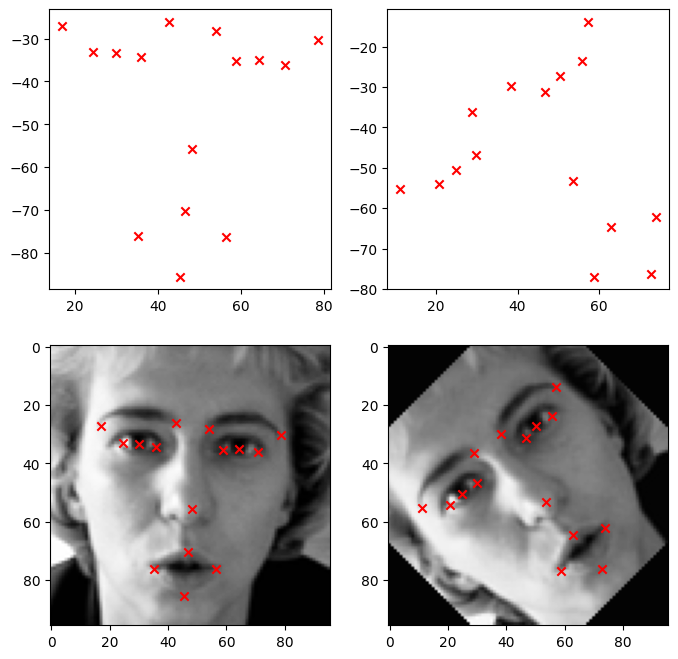

In [20]:
img_rot, feat_rot = aug_rotate(images[:5], targets[:5], angle=45)
show_augmentation(images[1], targets[1], img_rot[1], feat_rot[1])

## Brightness

In [21]:
def aug_bright(images, features, factor=1.5):
    bright = []
    for img in images:
        bright.append(np.clip(img * factor, 0, 255))
    return np.array(bright), features

augmentation_functions["brightness"] = aug_bright

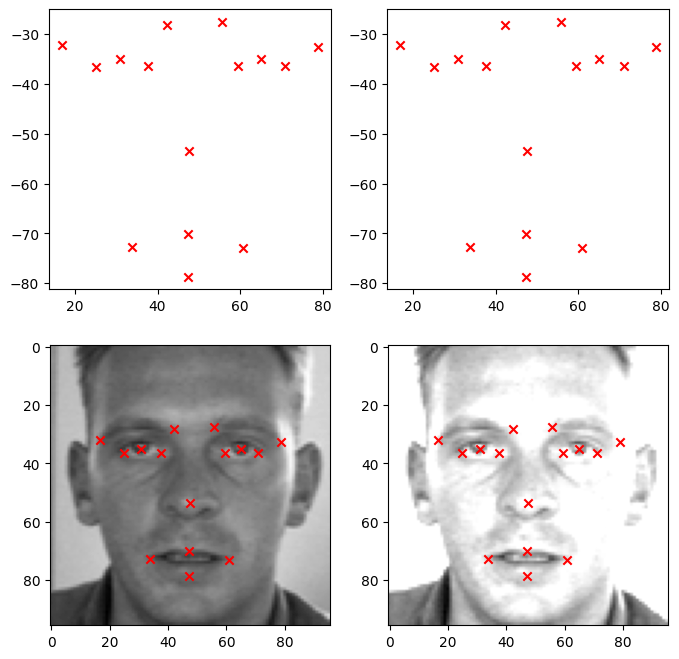

In [22]:
bright, features = aug_bright(images[:5], targets[:5], factor=2)
show_augmentation(images[2], targets[2], bright[2], features[2])

## Noise

In [23]:
def aug_noise(images, features, factor):
    augmented = []
    noise = np.random.randint(low=0, high=255, size=images.shape[1:])
    for img_og in images:
        img = img_og.copy()
        img += noise * factor
        augmented.append(img)
    return np.array(augmented), features

augmentation_functions["noise"] = aug_noise

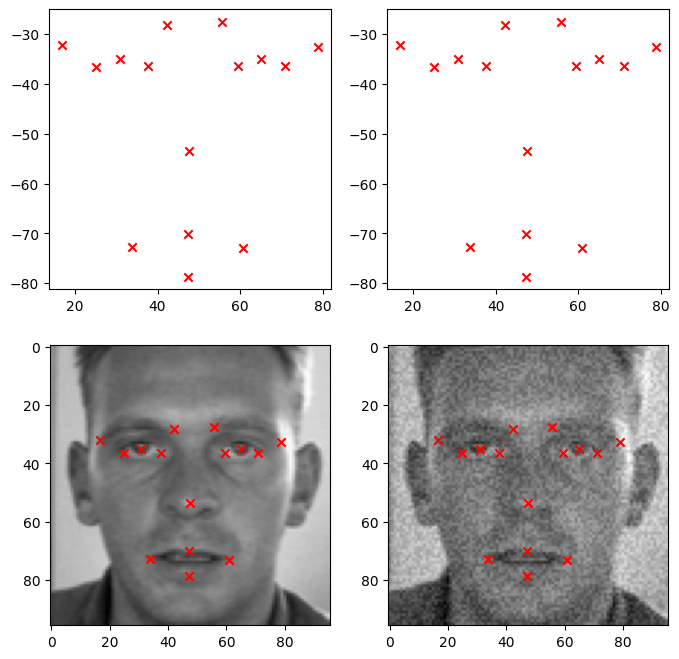

In [24]:
img, ft = aug_noise(images[:5], targets[:5], factor=0.2)
show_augmentation(images[2], targets[2], img[2], ft[2])

## Add Augmentation

In [25]:
def add_augmentation(img, feat, method):
    aug_img, aug_feat = method
    img = np.concatenate([img, aug_img])
    feat = np.concatenate([feat, aug_feat])
    return img, feat

In [26]:
# flip
method = aug_flip(images, targets)
augmented_images, augmented_targets = add_augmentation(images, targets, method)
print("Augmentation added: Flipping")

# crop
method = aug_crop(images, targets)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Cropping")

# rotate
for theta in [10, 12, 15, -10, -12, -15]:
    method = aug_rotate(images, targets, angle=theta)
    augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
    print("Augmentation added: Rotation: ", theta)

# brightness
method = aug_bright(images, targets)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Brightness")

# noise
method = aug_noise(images, targets, factor=0.2)
augmented_images, augmented_targets = add_augmentation(augmented_images, augmented_targets, method)
print("Augmentation added: Noise")

Augmentation added: Flipping
Augmentation added: Cropping
Augmentation added: Rotation:  10
Augmentation added: Rotation:  12
Augmentation added: Rotation:  15
Augmentation added: Rotation:  -10
Augmentation added: Rotation:  -12
Augmentation added: Rotation:  -15
Augmentation added: Brightness
Augmentation added: Noise


## Shape of new data

In [27]:
print("Shape of data after augmentation:")
print("Shape of image data  - ", augmented_images.shape)
print("Shape of target data - ", augmented_targets.shape)

Shape of data after augmentation:
Shape of image data  -  (23540, 96, 96, 1)
Shape of target data -  (23540, 30)


## Visualize the new data

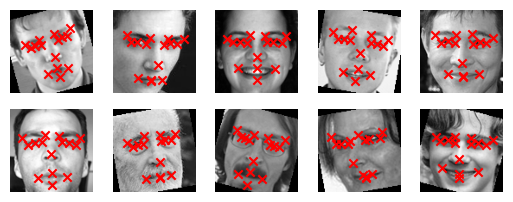

23540


In [28]:
def visualize_data(images, targets):
    for i in range(10):
        idx = np.random.randint(images.shape[0])
        plt.subplot(2, 5, i + 1)
        show_images(augmented_images[idx], augmented_targets[idx])
        plt.axis("off")
    plt.subplots_adjust(bottom=0.5)
    plt.show()

visualize_data(augmented_images, augmented_targets)
print(augmented_images.shape[0])

# Model

In [29]:
pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

In [30]:
augmented_images = tf.keras.applications.mobilenet_v2.preprocess_input(augmented_images)

In [31]:
# create a dataset for training and validation
ds = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_targets))
ds = ds.shuffle(buffer_size=augmented_targets.shape[0])
ds = ds.batch(64)
ds = ds.prefetch(tf.data.AUTOTUNE)

In [32]:
train_ds = ds.skip(10).shuffle(100)
val_ds = ds.take(10)

In [33]:
# create a preprocessing layer
class ImageTile(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(trainable=False)

    def call(self, inputs):
        return tf.tile(inputs, tf.constant([1, 1, 1, 3]))

In [34]:
def FFNN(units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu")
    ])

In [35]:
block = []
for units in [512, 256, 128, 64]:
    block.append(FFNN(units))

In [36]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 1)),
    ImageTile(),
    pretrained_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    *block,
    tf.keras.layers.Dense(30)
])

In [37]:
model.layers[1].trainable = False

In [38]:
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy", "mae", "mse"])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_tile (ImageTile)      (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 sequential (Sequential)     (None, 512)               657920    
                                                                 
 sequential_1 (Sequential)   (None, 256)               132352    
                                                                 
 sequential_2 (Sequential)   (None, 128)              

In [40]:
# decaying learning rate
def decay_lr(epoch):
    return 0.01 * math.pow(0.77, epoch)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay_lr)
lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [41]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping, lr_on_plateau])

Epoch 1/20
358/358 [==============================] - 106s 281ms/step - loss: 1798.7827 - accuracy: 0.0180 - mae: 37.5801 - mse: 1798.7827 - val_loss: 1046.1072 - val_accuracy: 0.1156 - val_mae: 27.2976 - val_mse: 1046.1072 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 92s 256ms/step - loss: 362.4915 - accuracy: 0.2255 - mae: 13.7531 - mse: 362.4915 - val_loss: 139.0732 - val_accuracy: 0.3719 - val_mae: 8.4302 - val_mse: 139.0732 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 90s 250ms/step - loss: 74.9529 - accuracy: 0.5548 - mae: 5.8920 - mse: 74.9529 - val_loss: 63.3069 - val_accuracy: 0.6359 - val_mae: 4.9644 - val_mse: 63.3069 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 90s 251ms/step - loss: 50.8512 - accuracy: 0.6312 - mae: 4.2813 - mse: 50.8512 - val_loss: 49.2972 - val_accuracy: 0.6344 - val_mae: 4.0081 - val_mse: 49.2972 - lr: 0.0010
Epoch 5/20
358/358 [==============================] - 91s 253ms/step - loss: 43.

## Prediction

In [42]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [43]:
test_images = get_images(test)
test_images = tf.keras.applications.mobilenet_v2.preprocess_input(test_images)
test_ds = tf.data.Dataset.from_tensor_slices((test_images)).batch(64)

In [44]:
test_preds = model.predict(test_ds)

28/28 [==============================] - 7s 230ms/step


In [45]:
print("Shape of test predictions: ", test_preds.shape)

Shape of test predictions:  (1783, 30)


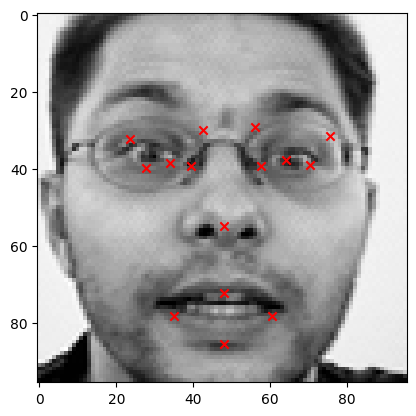

In [46]:
show_images(test_images[0], test_preds[0])

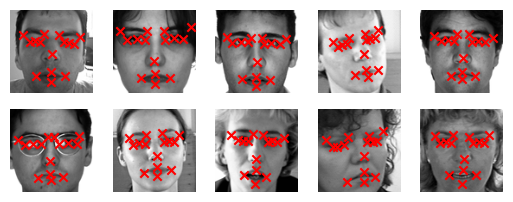

In [47]:
visualize_data(test_images, test_preds)

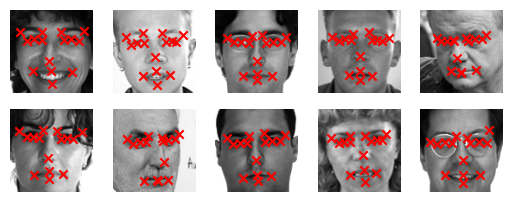

In [48]:
visualize_data(test_images, test_preds)

## Fine tune the model

In [50]:
print("Layers in the pre-trained model: ", len(model.layers[1].layers))

Layers in the pre-trained model:  154


In [52]:
model.layers[1].trainable = True

In [55]:
for layer in model.layers[1].layers[:-50]:
    layer.trainable = False

In [56]:
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy", "mae", "mse"])

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_tile (ImageTile)      (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 sequential (Sequential)     (None, 512)               657920    
                                                                 
 sequential_1 (Sequential)   (None, 256)               132352    
                                                                 
 sequential_2 (Sequential)   (None, 128)              

In [58]:
lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(patience=2)

early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=3,
                        restore_best_weights=True)


history = model.fit(train_ds, epochs=10, 
                    validation_data=val_ds, 
                    callbacks=[early_stopping,lr_on_plateau])

Epoch 1/10
358/358 [==============================] - 166s 441ms/step - loss: 33.4202 - accuracy: 0.7016 - mae: 3.0834 - mse: 33.4202 - val_loss: 159.1999 - val_accuracy: 0.6625 - val_mae: 7.2307 - val_mse: 159.1999 - lr: 0.0010
Epoch 2/10
358/358 [==============================] - 151s 422ms/step - loss: 19.5330 - accuracy: 0.7241 - mae: 2.3615 - mse: 19.5330 - val_loss: 62.8617 - val_accuracy: 0.6344 - val_mae: 4.6236 - val_mse: 62.8617 - lr: 0.0010
Epoch 3/10
358/358 [==============================] - 153s 427ms/step - loss: 16.7564 - accuracy: 0.7277 - mae: 2.1988 - mse: 16.7564 - val_loss: 152.8292 - val_accuracy: 0.6859 - val_mae: 6.9820 - val_mse: 152.8292 - lr: 0.0010
Epoch 4/10
358/358 [==============================] - 157s 438ms/step - loss: 13.4265 - accuracy: 0.7363 - mae: 2.0100 - mse: 13.4265 - val_loss: 68.5726 - val_accuracy: 0.6391 - val_mae: 4.8585 - val_mse: 68.5726 - lr: 0.0010
Epoch 5/10
358/358 [==============================] - 1770s 5s/step - loss: 9.8366 - acc

In [59]:
test_preds = model.predict(test_ds)

28/28 [==============================] - 9s 234ms/step


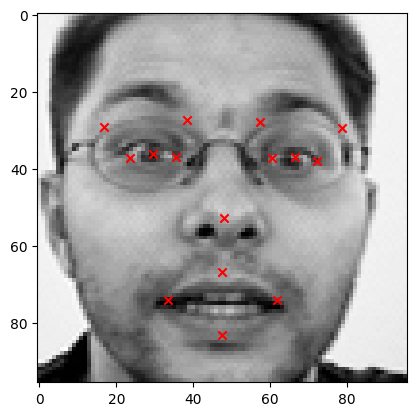

In [60]:
show_images(test_images[0], test_preds[0])

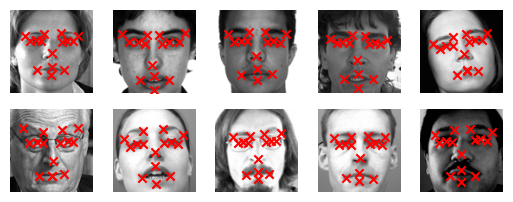

In [61]:
visualize_data(test_images, test_preds)

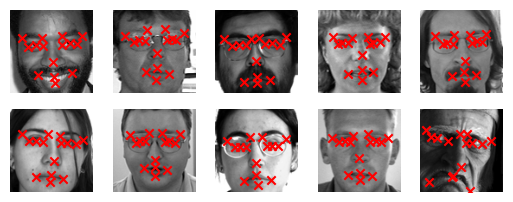

In [62]:
visualize_data(test_images, test_preds)

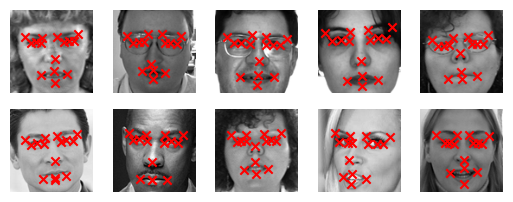

In [63]:
visualize_data(test_images, test_preds)

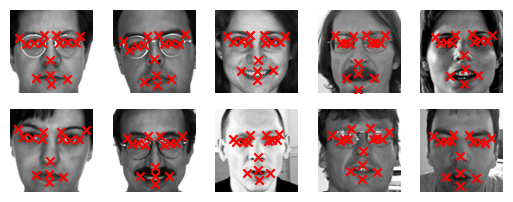

In [64]:
visualize_data(test_images, test_preds)

## Submission

In [66]:
feature_names = list(lookup['FeatureName'])
image_ids = list(lookup['ImageId']-1)
row_ids = list(lookup['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))  

predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])  

row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)

submission_result.to_csv('submission.csv',index = False)